In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/BAH_dataset/Train_Final_dataset/new_dataset_annotation.json", "/content/drive/MyDrive/BAH_dataset/Train_Final_dataset")
register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/BAH_dataset/val_Final_Dataset/val_annotations.json", "/content/drive/MyDrive/BAH_dataset/val_Final_Dataset")


[12/31 11:13:59 d2.data.datasets.coco]: Loaded 242 images in COCO format from /content/drive/MyDrive/BAH_dataset/Train_Final_dataset/new_dataset_annotation.json


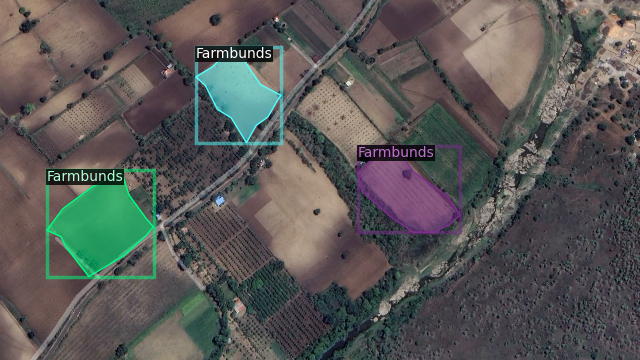

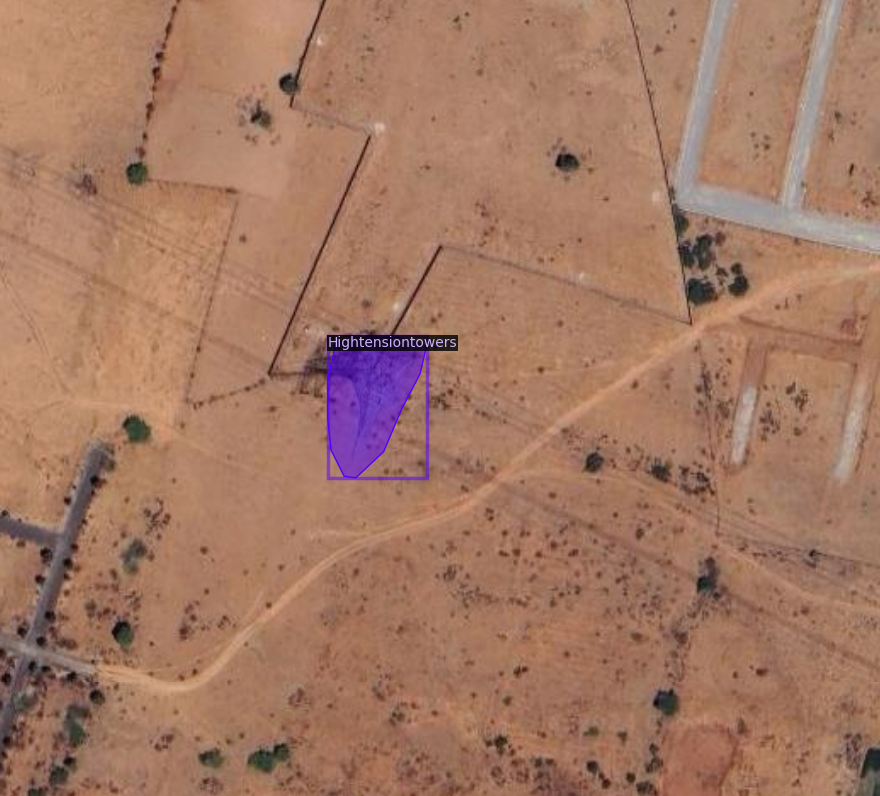

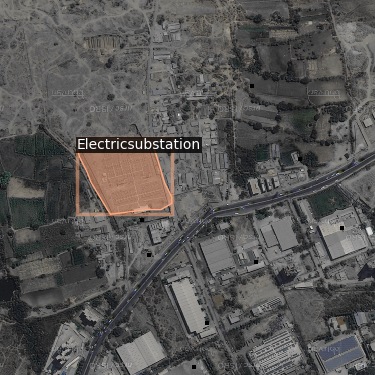

In [19]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/drive/MyDrive/BAH_dataset/val_Final_Dataset/*[jp][pn]g'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#test_metadata.thing_classes = ['Electric_Substation', 'High_Tension_Tower', 'FarmBunds', 'Brick_Kiln', 'Windmill']  # Replace with your class names

In [ ]:
def visualize_predictions(image_path, predictor, metadata):
    """
    Visualize Detectron2 predictions with class names and confidence scores

    Args:
        image_path (str): Path to the input image
        predictor: Detectron2 DefaultPredictor instance
        metadata: Dataset metadata containing class names
    """
    # Read image
    im = cv2.imread(image_path)

    # Get predictions
    outputs = predictor(im)

    # Create visualizer instance
    v = Visualizer(
        im[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW   # This will make the segmentation masks more visible
    )

    # Draw predictions
    instances = outputs["instances"].to("cpu")

    # Get additional information
    if instances.has("pred_classes"):
        classes = instances.pred_classes
        scores = instances.scores

        # Draw predictions with class names and scores
        out = v.draw_instance_predictions(instances)

        # Add text for class names and scores
        result_image = out.get_image()[:, :, ::-1]

        # Print prediction information
        print(f"Found {len(classes)} instances in {os.path.basename(image_path)}")
        for i, (cls, score) in enumerate(zip(classes, scores)):
            class_name = metadata.thing_classes[cls]
            print(f"Instance {i+1}: {class_name} (Score: {score:.2f})")

        return result_image
    else:
        print("No instances detected in the image")
        return im

# Process all images in the directory
image_directory = '/content/drive/MyDrive/BAH_dataset/val_Final_Dataset'
for image_path in glob.glob(os.path.join(image_directory, '*.[jp][pn]g')):
    # Visualize predictions
    result_image = visualize_predictions(image_path, predictor, test_metadata)

    # Display result
    cv2_imshow(result_image)
